In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- グローバル定数・ラベル ---
S = 'S'
I = 'I'
R = 'R'

# 散布図で色を分ける場合に使用するマップ (本コードでは使用しません)
color_map = {
    S: 'white',
    I: 'red',
    R: 'blue'
}

def initialize_grid(n, s_count, i_count, r_count):
    """
    グリッド(n x n)を用意し、
    各セル = 空リスト [] として初期化しておく。
    
    そこに S, I, R をランダム配置する。
    """
    # 全セルをリストとして初期化
    grid = np.empty((n, n), dtype=object)
    for x in range(n):
        for y in range(n):
            grid[x, y] = []  # 各セルは空のリスト
    
    # 全セル座標リストをシャッフルし、先頭からS,I,Rを詰める
    all_positions = [(x, y) for x in range(n) for y in range(n)]
    random.shuffle(all_positions)
    
    # Sを配置
    for _ in range(s_count):
        x, y = all_positions.pop()
        grid[x, y].append(S)
    
    # Iを配置
    for _ in range(i_count):
        x, y = all_positions.pop()
        grid[x, y].append(I)
    
    # Rを配置
    for _ in range(r_count):
        x, y = all_positions.pop()
        grid[x, y].append(R)
    
    return grid


def step_sir(old_grid, infection_prob, recovery_prob):
    """
    1ステップ進める:
      (A) 移動フェーズ
      (B) 感染/回復フェーズ
    old_grid[x, y] は「複数のエージェントを含むリスト」になっている。
    """
    n = old_grid.shape[0]
    
    # (A) 移動フェーズ
    # new_gridを作り、すべて空リストにしておく
    new_grid = np.empty((n, n), dtype=object)
    for xx in range(n):
        for yy in range(n):
            new_grid[xx, yy] = []
    
    # 移動対象を (x, y, 状態) のリストにまとめる
    movers = []
    for x in range(n):
        for y in range(n):
            for agent_state in old_grid[x, y]:
                movers.append((x, y, agent_state))
    random.shuffle(movers)
    
    # 移動処理 (エージェント1つずつ)
    for x, y, state in movers:
        # 8近傍からランダムに1か所を選ぶ (トーラス構造)
        dx, dy = random.choice([
            (-1, -1), (-1, 0), (-1, 1),
            (0, -1),           (0, 1),
            (1, -1),  (1, 0),  (1, 1)
        ])
        nx = (x + dx) % n
        ny = (y + dy) % n
        
        # 重複OKなので、そのまま移動先に追加
        new_grid[nx, ny].append(state)
    
    # (B) 感染/回復フェーズ
    updated_grid = np.empty((n, n), dtype=object)
    for xx in range(n):
        for yy in range(n):
            updated_grid[xx, yy] = new_grid[xx, yy].copy()
    
    for x in range(n):
        for y in range(n):
            cell_agents = new_grid[x, y]
            
            # 1. 回復処理: I -> R (確率 recovery_prob)
            for idx, st in enumerate(cell_agents):
                if st == I:
                    if random.random() < recovery_prob:
                        updated_grid[x, y][idx] = R
            
            # 2. 感染処理: S -> I (近傍にIが1つでもいれば確率 infection_prob で感染)
            infected_neighbor_found = False
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx = (x + dx) % n
                    ny = (y + dy) % n
                    # 近傍セルにIがいれば感染の可能性あり
                    if any(agent == I for agent in new_grid[nx, ny]):
                        infected_neighbor_found = True
                        break
                if infected_neighbor_found:
                    break
            
            if infected_neighbor_found:
                for idx, st in enumerate(updated_grid[x, y]):
                    if st == S:
                        if random.random() < infection_prob:
                            updated_grid[x, y][idx] = I
    
    return updated_grid


def count_SIR(grid):
    """
    グリッド全体での S, I, R の数を数える
    """
    s_count = 0
    i_count = 0
    r_count = 0
    n = grid.shape[0]
    for x in range(n):
        for y in range(n):
            for st in grid[x, y]:
                if st == S:
                    s_count += 1
                elif st == I:
                    i_count += 1
                elif st == R:
                    r_count += 1
    return s_count, i_count, r_count


def run_sir_simulation(n, s_count, i_count, r_count, infection_prob, recovery_prob, steps):
    """
    初期化したグリッドに対し、steps回ステップを進める。
    各ステップ終了時点での感染者数 I をリストで返す。
    """
    # グリッド初期化
    grid = initialize_grid(n, s_count, i_count, r_count)
    
    # 初期状態含め、感染者数を記録
    i_list = []
    s0, i0, r0 = count_SIR(grid)
    i_list.append(i0)
    
    # シミュレーションを steps 回進める
    for _ in range(steps):
        grid = step_sir(grid, infection_prob, recovery_prob)
        s_cnt, i_cnt, r_cnt = count_SIR(grid)
        i_list.append(i_cnt)
    
    return i_list



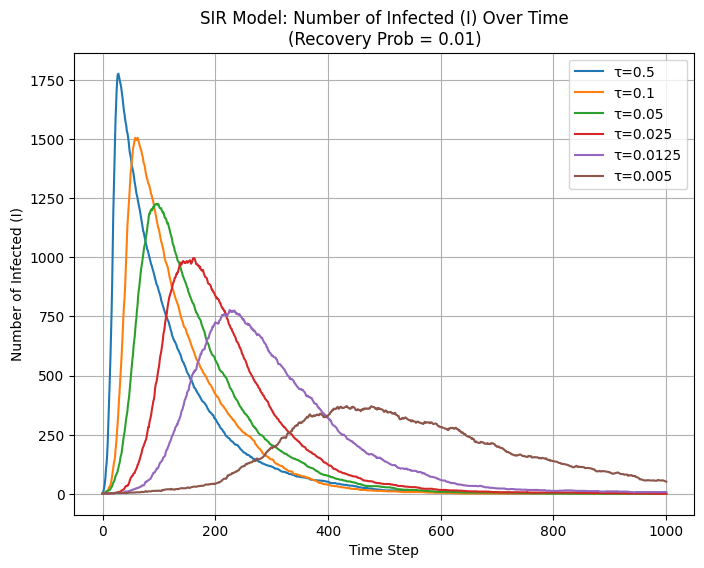

In [6]:
# ------------------------------
# ここからメイン処理
# ------------------------------

# 再現性を持たせたい場合は乱数シードを固定（必要に応じてコメントアウト）
# random.seed(0)
# np.random.seed(0)

# パラメータ設定
N = 50           # グリッドの大きさ: 50 x 50
INITIAL_S = 2000 # 初期Susceptible数
INITIAL_I = 1   # 初期Infected数
INITIAL_R = 0    # 初期Recovered数
RECOVERY_PROB = 0.01  # 回復確率(γ) は固定
NUM_STEPS = 1000      # シミュレーションステップ数

# 各種感染確率 (τ)
infection_probs = [0.5,0.1, 0.05, 0.025, 0.0125,0.005]

# 結果を重ねて描画する準備
plt.figure(figsize=(8, 6))

for tau in infection_probs:
    i_list = run_sir_simulation(
        n = N,
        s_count = INITIAL_S,
        i_count = INITIAL_I,
        r_count = INITIAL_R,
        infection_prob = tau,
        recovery_prob = RECOVERY_PROB,
        steps = NUM_STEPS
    )
    
    # ステップ数に合わせて x 軸を作成 (0 ~ NUM_STEPS)
    x_values = np.arange(len(i_list))
    plt.plot(x_values, i_list, label=f"τ={tau}")

# グラフの装飾
plt.title("SIR Model: Number of Infected (I) Over Time\n(Recovery Prob = 0.01)")
plt.xlabel("Time Step")
plt.ylabel("Number of Infected (I)")
plt.legend()
plt.grid(True)
plt.show()
